In [ ]:
!pip3 install astropy

In [ ]:
!pip3 install requests

In [ ]:
!pip3 install sklearn

In [10]:
!pip3 install pandas

     |████████████████████████████████| 6.3MB 3.2MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from astropy.units import one
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten , Dropout, Activation, BatchNormalization, Input, LeakyReLU
from tensorflow.keras.layers import LSTM, GRU, CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import concatenate as Concatenate
from tensorflow.keras.models import Model
from tensorflow.contrib.opt import MomentumWOptimizer, AdamWOptimizer
from tensorflow.keras.regularizers import l2
#from keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import itertools
import random
import math
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, precision_recall_curve, average_precision_score, roc_auc_score, roc_curve, auc

from IPython.display import clear_output

from tensorflow.keras import backend as K
#from tensorflow.keras.engine.topology import Layer

from tensorflow.keras.layers import Layer 
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate, InputSpec
import tensorflow as tf

In [12]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# # # memory footprint support libraries/code
# # !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# # !pip install gputil
# # !pip install psutil
# # !pip install humanize

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)
# InteractiveSession.close()

In [28]:

is_on_colab = False

is_show_colab_env_info = True



if(is_on_colab):

    if(is_show_colab_env_info):
        import psutil
        import humanize
        import os
        import GPUtil as GPU
        GPUs = GPU.getGPUs()
        # XXX: only one GPU on Colab and isn’t guaranteed
        gpu = GPUs[0]
        
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

        #GPU count and name
        !lscpu |grep 'Model name'
        !nvidia-smi -L
        printm()
  
  
    from google.colab import drive
    drive.mount('/content/drive')

    gdrive_home_dir = '/content/drive/My Drive/'

    project_dir = f'{gdrive_home_dir}DeepCNC/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'

    !ls '{ds_dir}'

else:
    project_dir = f'../../../SpliceSite/'
    ds_dir = f'{project_dir}data/'
    snapshot_dir = f'{project_dir}snapshots/'


  

In [31]:
fnmInput = f'{ds_dir}input.txt'; 
#fnmLabel= f'{ds_dir}inputLabel_0-1.txt'

fnmLabel= f'{ds_dir}inputLabel_1-0.txt'


In [32]:
with open(fnmInput,'r') as f:
    print(len(f.readlines()))
    
    
with open(fnmLabel,'r') as f:
    print(len(f.readlines()))

93719
93719


In [33]:
########################### Stratified k-fold Cross validation: IMBALANCED SET ###############

# train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels,
#                                                                                 test_size=hyper_test_split,
#                                                                                 stratify=input_labels,
#                                                                                 random_state=42)

useFullDataSet = False;
ratio_High_Low = 10;

with open(fnmLabel) as f:
    labels = [ int(x) for x in f.read().split()]
    
pos_samplecount = labels.count(1)
neg_samplecount = labels.count(0)
print(pos_samplecount, neg_samplecount)


totPos = pos_samplecount
totNeg = neg_samplecount 

2796 90923


In [34]:
#totPos = 2796;
#totNeg = 90923;  # 93719- 2796;

totPosNeg = totPos + totNeg;
print("totPos: ", totPos, " totNeg: ", totNeg)
stepSize = 1;

posIndex = [ i for i in range(len(labels)) if labels[i] == 1 ]
negIndex = [ i for i in range(len(labels)) if labels[i] == 0 ]


totPos:  2796  totNeg:  90923


In [35]:
#posIndex = [i for i in range(0, totPos, stepSize)];
#negIndex = [j for j in range(totPos, totPosNeg, stepSize)];

print("Printing index")

sizePos = len(posIndex)
sizeNeg = len(negIndex)

print("size of pos :", sizePos)
print("size of neg :", sizeNeg)

negIndexShuffled = negIndex
random.shuffle(negIndexShuffled)

ratio_High_Low_Max = math.floor(sizeNeg/ sizePos)

if ratio_High_Low > ratio_High_Low_Max:
    ratio_High_Low = ratio_High_Low_Max;

print( 'Specified Pos:Neg ratio: ' , ratio_High_Low)


if useFullDataSet:
    mergedIndex = posIndex +  negIndexShuffled ;
    print("After selection size of pos :", len(posIndex))
    print("After selection size of neg :", len(negIndexShuffled ))
    print( ' len of merge: ' , len(mergedIndex) )
    
    
else:
    posIndex_Selected = posIndex
    negIndexShuffled_Selected = negIndexShuffled[0:totPos * ratio_High_Low]
    mergedIndex = posIndex_Selected +  negIndexShuffled_Selected ;
    print("After selection size of pos :", len(posIndex_Selected))
    print("After selection size of neg :", len(negIndexShuffled_Selected))
    print( 'len of merged set: ' , len(mergedIndex) )

# sequences_New = sequences[mergedIndex]
# labels_New  = labels[mergedIndex] 
# inp = input_features[mergedIndex]

Printing index
size of pos : 2796
size of neg : 90923
Specified Pos:Neg ratio:  10
After selection size of pos : 2796
After selection size of neg : 27960
len of merged set:  30756


In [36]:

# sequences_Orig = [ (line.strip())[15:-15] for line in open(fnmInput)] # .rstrip('\n')
#sequences_Orig = [ (line.strip()) for line in open(fnmInput)] # .rstrip('\n')
sequences_Orig = [ line.strip()[:1000] for line in open(fnmInput)] # .rstrip('\n')
sequences_Orig = list(filter(None, sequences_Orig))  # This removes empty sequences.

print('Total Seq found:' , len(sequences_Orig) )

sequences = [ sequences_Orig[i] for i in mergedIndex ]
print('Total Seq found AFTER selection:' , len(sequences) )


# Let's print the first few sequences.
df = pd.DataFrame(sequences_Orig, index=np.arange(1, len(sequences_Orig) + 1), columns=['Sequences'])
# print(df.head())
setNucleotide= set()
for seq in sequences_Orig:
    s = set (list(seq))
    setNucleotide = setNucleotide | s
#   print( len(sequence) )

print("Finally all nucleotides: ")
totalNuclType= setNucleotide.__len__()
print(totalNuclType)

with open(fnmInput ,'rt') as f:
    content = f.readlines()

content = [c.strip() for c in content]
content = "".join(content)
alphabet = list(set(content))
integer_encoder = LabelEncoder()
integer_encoder.fit(alphabet)
print("classes: " ,list(integer_encoder.classes_))


Total Seq found: 93719
Total Seq found AFTER selection: 30756
Finally all nucleotides: 
4
classes:  ['A', 'C', 'G', 'T']


In [37]:
####################  Encode Input Sequence ##############
one_hot_encoder = OneHotEncoder(categories=[range(len(integer_encoder.classes_))])
input_features = []
myBuffer = ''
count =1;
for sequence in sequences:
    integer_encoded = integer_encoder.transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())
    # myBuffer += ("Seq no:" + str(count) + "  len: " + str(len(sequence))  + " array len: " + str( len(one_hot_encoded.toarray()))  + "\n" )
    count = count + 1

print( "Encoding of input DONE")   
    


Encoding of input DONE


In [38]:
print( "Check Encoding Shape")
lengths = [f.shape for f in input_features]
print(set(lengths))    
    
np.set_printoptions(threshold=40)
input_features = np.stack( input_features )

print( len(input_features ) )

print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n' ,sequences[0][:10] ,'...' ,sequences[0][-10:])
print('One hot encoding of Sequence #1:\n' ,input_features[0].T)

Check Encoding Shape
{(140, 4)}
30756
Example sequence
-----------------------
DNA Sequence #1:
 CTCCTCTTTG ... GGTCACTGGG
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 1. 0. ... 0. 0. 0.]]


In [39]:
####################  Encode Label ##############

# def processLabel():
# LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'
# labels = requests.get(LABELS_URL).text.split('\n')
# labels = list(filter(None, labels))  # removes empty sequences
labels_Orig = [line.rstrip('\n') for line in open(fnmLabel)]
labels_Orig = list(filter(None, labels_Orig))  # This removes empty sequences.

labels = [ labels_Orig[i] for i in mergedIndex]

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n', labels.T)
print('One-hot encoded labels:\n', input_labels.T)
print( len(input_labels ) )

labels = np.array(list(map(int, labels)))  # added for sigmoid activation

####################  Encode Label End ##############

Labels:
 [['1' '1' '1' ... '0' '0' '0']]
One-hot encoded labels:
 [[0. 0. 0. ... 1. 1. 1.]
 [1. 1. 1. ... 0. 0. 0.]]
30756


In [40]:
k_folds=  10 # 10 # 2
hyper_epoch=  200 #50 # 5
class_weight = {0: 1., 1: 1.} # 10 

#class_weight = {0: ratio_High_Low, 1: 1.} # 10 
#print(ratio_High_Low)

hyper_classes=2

hyper_validation_split = 0.20
#hyper_test_split=0.10
#hyper_pool_size = (1,2)
hyper_batch_size = 64
# hyper_optimizer = 'Adadelta'
# hyper_init_mode = 'zero'
# hyper_activation = 'tanh'
# hyper_filter = 50
# hyper_filterL = 30
# hyper_filterW = 32
# hyper_neurons = 32
# hyper_dropout_rate = 0.1


model_history = []
dfHistory = pd.DataFrame( columns=['Precsion' , 'Recall' , 'Specificity' , 'Accuracy'])


In [41]:
# updatable plot

# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

class Plotter(Callback):
    
    def __init__(self):
        self.line_colors = plt.cm.tab20(np.linspace(0,1,20))
        
        self.tr_loss_color = self.line_colors[0]
        self.val_loss_color = self.line_colors[2]
        self.fold = 0

    def set_plot_color(self,idx):
        self.tr_loss_color = self.line_colors[idx%20]
        self.val_loss_color = self.line_colors[(idx+2)%20]
        self.fold = idx + 1

    def setMetrics(self, metrics):
        self.metrics = metrics
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=True)
        #fig = plt.Figure(figsize=(50, 10))
        #plt.cla()
        f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18,4))
        #ax1 = plt.subplot(121)
        ax1.plot(self.x, self.losses, label="loss", color = self.tr_loss_color,  alpha=1.0)
        ax1.plot(self.x, self.val_losses, label="val_loss", color = self.val_loss_color, alpha=1.0)
        ax1.legend()
        ax1.set_title("Fold: "+str(self.fold)+" epoch: "+str(epoch))
        
        #ax = fig.subplot(122), alpha=.7
        tmp = np.array(self.metrics.tp_tn_fp_fn)
        ax2.plot(self.x, tmp[:,2], label="False Positive", color = self.tr_loss_color, alpha=1.0)
        ax2.plot(self.x, tmp[:,3], label="False Negatives", color = self.val_loss_color, alpha=1.0)
        ax2.legend()
        ax2.set_title("FP & FN Fold: "+str(self.fold)+" epoch: "+str(epoch))
        
        
        ax3.plot(self.x, [self.metrics.b_mcc]*len(self.x), label="MCC", color = 'r', alpha=.7)
        ax3.plot(self.x, [self.metrics.b_sensitivity]*len(self.x), label="sensitivity", color = 'g', alpha=.7)
        ax3.plot(self.x, [self.metrics.b_specificity]*len(self.x), label="specificity", color = 'b', alpha=.7)
        ax3.plot(self.x, self.metrics.val_MCC, label="MCC", color = 'r')
        ax3.plot(self.x, self.metrics.val_sensitivity, label="sensitivity", color = 'g')
        ax3.plot(self.x, self.metrics.val_specificity, label="specificity", color = 'b')
                
        ax3.legend()
        ax3.set_title("MCC-Sensitivity-Specificity for Fold: "+str(self.fold)+" epoch: "+str(epoch))
        
        plt.show()
        plt.close()

In [42]:
# import keras.backend as K

# # https://keras.io/metrics/
# def my_pred(y_true, y_pred):
#     #return K.mean(y_pred)

# #     cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
#     cm = confusion_matrix(y_true, y_pred)
#     #print('Confusion matrix:\n' ,cm)
#     # cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
#     total1=sum(sum(cm))
#     accuracy1=(tp+tn)/total1
#     sensitivity1 = tp/(tp+fn)
#     specificity1 = tn/(fp+tn)
#     if (tp)==0:
#         precision1 = 0
#     else:
#         precision1 = tp / (tp + fp)

#     MCC = (tp*tn - fp*fn) / np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) 
#     return MCC

# # model.compile(optimizer='rmsprop',  loss='binary_crossentropy',   metrics=['accuracy', my_pred])

In [43]:
def perform_test( mdl, features, labels, cm_df, roc_df, dpr_df ):
    
    predicted_labels = (np.asarray(mdl.predict(np.stack(features)))).round()
    
    
    #cm = confusion_matrix(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
    cm = confusion_matrix(labels, predicted_labels)
    output = ""
    output = output + 'Confusion matrix:\n' + str(cm) 
    output += "\n"
    
    print('Confusion matrix:\n' ,cm)
    # cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    total1=sum(sum(cm))
    tp=cm[0,0];fn=cm[0,1];fp=cm[1,0];tn=cm[1,1];
    
    accuracy1=(tp+tn)/total1
    sensitivity1 = tp/(tp+fn)
    specificity1 = tn/(fp+tn)
    if (tp)==0:
        precision1 = 0
    else:
        precision1 = tp / (tp + fp)

    MCC = (tp*tn - fp*fn) / np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  )    
    print( "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC )) 

    output = output + "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC )
    output += "\n"
    
    cm_df =  dfCM.append( {  'tp': tp , 'fn' : fn , 'fp': fp  , 'tn' : tn  } , ignore_index=True)   
    
    #auc_roc           = roc_auc_score( np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1) )  
    auc_roc           = roc_auc_score( labels, predicted_labels )  
    #average_precision = average_precision_score(np.argmax(labels, axis=1), np.argmax(predicted_labels, axis=1))
    average_precision = average_precision_score(labels, predicted_labels )
    print( "area ROC : " , auc_roc ,  " area PR " , average_precision)
    output = output + " area ROC : " + str(auc_roc) +  " area PR " + str(average_precision)
    output += "\n"

    roc_df =  roc_df.append( {  'AREA_ROC': auc_roc  } , ignore_index=True) 
    dpr_df  =  dpr_df.append( {  'AREA_PR': average_precision  } , ignore_index=True) 
    
    return output

In [44]:

import tensorflow as tf

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)


def mcc_loss(y_true, y_pred):

    #tp_count = K.sum(K.round(K.cast(y_true*y_pred, 'float')))
    #tn_count = K.sum(K.round(K.cast((1-y_true)*(1-y_pred), 'float')))
    #fp_count = K.sum(K.round(K.cast((1-y_true)*y_pred, 'float')))
    #fn_count = K.sum(K.round(K.cast(y_true*(1-y_pred), 'float')))
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0) 
    #tp = tp + (tp_count - tp)
    
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    #tn = tn + (tn_count - tn)
    
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    #fp = fp + (fp_count - fp)
    
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    #fn = fn + (fn_count - fn)
    
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    mcc = (tp*tn - fp*fn) / (K.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + K.epsilon()) 
    mcc = tf.where(tf.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - mcc

In [45]:


class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())
    
    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

        #clear_output(wait=True)
        plt.cla()
        plt.plot(self.history['lr'], label="learning rate")
        plt.legend()
        plt.show();   
        
        
    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [46]:
# callbacks and metric computing functions

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def weighted_sen_and_spec(y_true, y_pred):    
    return 2*specificity(y_true, y_pred) + 1*sensitivity(y_true, y_pred)

def compute_precision(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    fp = possible_negatives - tn
    
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    fn = possible_positives - tp
    
    precision = tp/(tp + fp + K.epsilon())
    
    return precision
    
def compute_f1_score(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    fp = possible_negatives - tn
    
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    fn = possible_positives - tp
    
    precision = tp/(tp + fp + K.epsilon())
    recall = tp/(tp + fn + K.epsilon())
    
    return 2*precision*recall/(precision + recall + K.epsilon())
        
def compute_mcc(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    fp = possible_negatives - tn
    
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    fn = possible_positives - tp
    
    return (tp*tn - fp*fn) / (K.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + K.epsilon())    
        


class Metrics(Callback):
    
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.val_sensitivity = []
        self.val_specificity = []
        self.val_q9 = []
        self.val_MCC = []
        self.tp_tn_fp_fn = []
    
    def set_benchmark(self, b_sensitivity, b_specificity, b_mcc):
        self.b_sensitivity = b_sensitivity
        self.b_specificity = b_specificity
        self.b_mcc = b_mcc
        
    def set_fold(self, fold):
        self.fold = fold
    
    def on_train_begin(self, logs={}):
        pass    
    
    def _compute_q9(self, tp, tn, fp, fn):
        if(tp + fn) == 0:
            q_squared = (tn-fp)/(tn+fp)
        elif(tn + fp) == 0:
            q_squared = (tp-fn)/(tp+fn)            
        else:
            q_squared = 1 - np.sqrt(2 * ( (fn/(tp+fn))**2 + (fp/(tn+fp))**2 ) )
            
        tmp = q_squared**(9/2)
        
        q_9 = (1 + tmp)/2
        
        return q_9
    
    def on_epoch_end(self, epoch, logs={}):
        #print(dir(self.model))
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        
        cm = confusion_matrix(val_targ, val_predict)

        #cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        tn, fp, fn, tp = cm.ravel()

        #_val_q9 = self._compute_q9(tp, tn, fp, fn)
        
        _val_specificity = tn/(fp+tn)
        _val_sensitivity = tp/(tp+fn)
        _val_MCC = (tp*tn - fp*fn) / (np.sqrt(  (tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)  ) + K.epsilon())  
        
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self.val_sensitivity.append(_val_sensitivity)
        self.val_specificity.append(_val_specificity)
        
        #self.val_q9.append(_val_q9)
        self.val_MCC.append(_val_MCC)      
        #self.tp_tn_fp_fn = np.append(self.tp_tn_fp_fn, np.array([tp, tn, fp, fn]).reshape(1,4), axis = 0) 
        self.tp_tn_fp_fn.append((tp, tn, fp, fn)) 
        
        is_beaten_sens = False
        is_beaten_spec = False
        is_beaten_mcc = False
        
        if( _val_sensitivity > self.b_sensitivity ):
            #print('val_sensitivity '.ljust(21),f':{_val_sensitivity} ')
            #print('bechmark_sensitivity '.ljust(21),f':{self.b_sensitivity} ')
            is_beaten_sens = True

        if( _val_specificity > self.b_specificity ):
            #print('val_specificity '.ljust(21),f':{_val_specificity} ')
            #print('bechmark_specificity '.ljust(21),f':{self.b_specificity} ')
            is_beaten_spec = True

        if( _val_MCC > self.b_mcc):
            #print('val_mcc '.ljust(21),f':{_val_MCC} ')
            #print('bechmark_mcc '.ljust(21),f':{self.b_mcc} ')
            is_beaten_mcc = True
        
        
        print(f'_________________________________________ METRICS for epoch {epoch} _______________________________________________________')
        print('val_f1 '.ljust(16),f':{_val_f1}  ')
        print('val_precision '.ljust(16),f':{_val_precision} ')
        print('val_recall '.ljust(16),f':{_val_recall}')
        print('val_sensitivity '.ljust(16),f':{_val_sensitivity:.5f} ',f' bmark:({self.b_sensitivity:.4f})',f' sen.beaten:{is_beaten_sens}')
        print('val_specificity '.ljust(16),f':{_val_specificity:.5f} ',f' bmark:({self.b_specificity:.4f})',f' spe.beaten:{is_beaten_spec}')
        print('val_MCC '.ljust(16),f':{_val_MCC:.5f} ',f' bmark:({self.b_mcc:.4f})',f' mcc.beaten:{is_beaten_mcc}')
        print( '---------------------') 
        print(f'| tp:{tp} '.ljust(9),f'| fp:{fp}'.ljust(9),'|')
        print(f'| fn:{fn} '.ljust(9),f'| tn:{tn}'.ljust(9),'|')
        print('---------------------') 
        
        if(is_beaten_sens and is_beaten_spec and is_beaten_mcc):
            print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
            print(f'##############################  BEATEN ALL at epoch:{epoch} of fold:{self.fold} ###########################################')
            print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

        print()
        print('_________________________________________ EPOCH END _______________________________________________________________________')
        print()
        
        return
    

In [47]:
def make_model():
    
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------        
    # -------------------------------------------------------------------------------------------------------------------------------------
    def make_seq_cnn():
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
        model.add(Conv1D(filters=64, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) # input = 129 * 32
        model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=48, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

    #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
    #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
    #     #model.add(BatchNormalization())    
    #     model.add(Activation('relu'))
    #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
    #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
        #model.add(Dropout(rate = 0.4))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        model.add(Dense(32, kernel_regularizer=l2(0.02) ) )
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.6)) 
        model.add(Dense(2, kernel_regularizer=l2(0.02)))        
        model.add(Activation('softmax'))
        
        SGDRScheduler_config = { 'min_lr':2e-4,
                                 'max_lr':.2e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.001, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]

    
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------        
    # -------------------------------------------------------------------------------------------------------------------------------------
    def make_seq_3mer_cnn():
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        model.add(Conv1D(filters=92, kernel_size=3 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) # input = 129 * 32
        model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=48, kernel_size=3, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

#         #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
#         model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
#         model.add(BatchNormalization())    
#         model.add(Activation('relu'))
#         model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
#         model.add(MaxPooling1D(pool_size = 2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

    #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
    #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
    #     #model.add(BatchNormalization())    
    #     model.add(Activation('relu'))
    #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
    #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        #model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(1e-6), recurrent_regularizer=l2(1e-6), bias_regularizer=l2(1e-6)) ))
        #model.add(Dropout(rate = 0.4))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        model.add(Dense(48, kernel_regularizer=l2(0.02) ) )
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.6)) 
        model.add(Dense(2, kernel_regularizer=l2(0.02)))        
        model.add(Activation('softmax'))
        
        SGDRScheduler_config = { 'min_lr':2e-4,
                                 'max_lr':5e-4,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 5,
                                 'mult_factor': 1.5}
        
        config = {'learning_rate':0.001, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]    
    
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ sequential definition --------------------------------------------------------------------
    # -------------------------------------------------------------------------------------------------------------------------------------
    def make_seq_cnn_blstm():
        
        # regularization: https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

        model = Sequential()

        #model.add(Conv1D(filters=32, kernel_size=8 ,input_shape=( inputSeqLength, totalNuclType ))  )
        model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # input = 129 * 32
        model.add(MaxPooling1D(pool_size= 2 ))#totalNuclType)) # input = 129 * 32 , output= 32*32 (filter/pool_size* filterTotal)

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(4e-4), bias_regularizer=l2(4e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size=2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32

        #model.add(Conv1D(filters=32, kernel_size=8))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
        model.add(Conv1D(filters=32, kernel_size=12, kernel_regularizer=l2(8e-4), bias_regularizer=l2(8e-4) )  )    
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
        model.add(MaxPooling1D(pool_size =2 ))#totalNuclType))  # input = 25 *32 , output 6 * 32    

    #     model.add(Conv1D(filters=92, kernel_size=3))#, input_shape=(32, 32))) # inputSeqLength, totalNuclType
    #     #model.add(Conv1D(filters=32, kernel_size=12 ,input_shape=( inputSeqLength, totalNuclType ), kernel_regularizer=l2(4e-5), bias_regularizer=l2(4e-5) )  )    
    #     #model.add(BatchNormalization())    
    #     model.add(Activation('relu'))
    #     model.add(Dropout(rate = 0.4)) # (32-8)/1  + 1 = 25 , output = 25 *32
    #     model.add(MaxPooling1D(pool_size=totalNuclType))  # input = 25 *32 , output 6 * 32  


        #model.add(Bidirectional(LSTM(16, return_sequences=True)))
        model.add(Bidirectional(CuDNNGRU(240, return_sequences=True, kernel_regularizer=l2(4e-3), recurrent_regularizer=l2(5e-3), bias_regularizer=l2(4e-3)) ))
        model.add(Dropout(rate = 0.6))    

        model.add(Flatten())

        #model.add(Dense(16))
        #  cite: use weight decay increasing from 0 to 1E-5 at 1200 epochs, to 1E-4 at 2500 epochs, and to 1E-3 at 400 epochs. 
        # […] The surface is smoother and transitions are more gradual
        model.add(Dense(16, kernel_regularizer=l2(0.01) ) )
        model.add(BatchNormalization())    
        model.add(Activation('relu'))
        model.add(Dropout(rate = 0.5)) 
        model.add(Dense(2, kernel_regularizer=l2(0.01)))        
        model.add(Activation('softmax'))
        
#         SGDRScheduler_config = { 'min_lr':2e-4,
#                                  'max_lr':.2e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 5,
#                                  'mult_factor': 1.5}

#         SGDRScheduler_config = { 'min_lr':5e-4,
#                                  'max_lr':.5e-3,
#                                  'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
#                                  'lr_decay':0.95,
#                                  'cycle_length': 2,
#                                  'mult_factor': 1.5}        


        SGDRScheduler_config = { 'min_lr':1e-4,
                                 'max_lr': .5e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length': 2,
                                 'mult_factor': 1.5}        
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]    
    
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ functional definition --------------------------------------------------------------------        
    # -------------------------------------------------------------------------------------------------------------------------------------
    
    def make_func_inception():
        input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

        def create_inception_module(input_tensor):
            c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
            c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
            c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
            #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
            #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
            inception_module = Concatenate([c3, c5, c8], axis = 2)
            
            
            #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
            #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
            #inception_module = c8

            return inception_module

        out = create_inception_module(input_2d)
        #out = Dropout(rate = 0.1)(out)  # was 0.4
        out = Dropout(rate = 0.4)(out)  # was 0.4
        out = MaxPooling1D(pool_size = totalNuclType)(out)


        out = create_inception_module(out)
        #out = Dropout(rate = 0.1)(out) # was 0.4
        out = Dropout(rate = 0.4)(out) # was 0.4
        out = MaxPooling1D(pool_size = totalNuclType)(out)

        out = Conv1D(filters=32, kernel_size=8)(out)
        out = Activation('relu')(out)     
        #out = Dropout(rate = 0.45)(out) # was 0.4
        out = Dropout(rate = 0.4)(out) # was 0.4
        out = MaxPooling1D(pool_size = totalNuclType)(out)

    #     out = Bidirectional( LSTM(16, return_sequences=True))(out)
    #     out = Bidirectional( LSTM(16, return_sequences=True))(out)    
    #     out = Dropout(rate = 0.25)(out)

        out = Flatten()(out)
        out = Dense(16)(out)
        out = Activation('relu')(out)
        out = Dropout(rate = 0.5)(out)

        #out = Dense(2, activation='softmax')(out)
        out = Dense(1, activation='sigmoid')(out)

        model = Model(inputs = input_2d, outputs = out)        
    
        SGDRScheduler_config = { 'min_lr':3e-5,
                                 'max_lr':1e-3,    #0.5e-3, #1e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length':10,
                                 'mult_factor': 1.0}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]
    
    
    
    # -------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------ functional definition --------------------------------------------------------------------        
    # -------------------------------------------------------------------------------------------------------------------------------------
    
    def make_func_inception_small():
        input_2d = Input(shape = ( inputSeqLength, totalNuclType ))

        def create_inception_module(input_tensor):
            c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
            c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
            c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
            #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
            #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
            inception_module = Concatenate([c3, c5, c8], axis = 2)
            
            
            #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
            #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
            #inception_module = c8

            return inception_module

        def create_resnet_module(input_tensor):
            c3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_tensor)
            c5 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(input_tensor)
            c8 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_tensor)
            #c12 = Conv1D(filters=32, kernel_size=12, padding='same', activation='relu')(input_tensor)
            #inception_module = Concatenate([c3, c5, c8, c12], axis = 2)
            inception_module = Concatenate([c3, c5, c8, input_tensor], axis = 2)
            
            
            #p3 = MaxPooling1D(pool_size=2, strides=1, padding='same')(input_tensor)
            #pool = MaxPooling1D(pool_size = totalNuclType, strides=1, padding='same')(c8)
            #inception_module = c8

            return inception_module        
        
        out = create_inception_module(input_2d)
        #out = Dropout(rate = 0.1)(out)  # was 0.4
        out = Dropout(rate = 0.4)(out)  # was 0.4
        out = MaxPooling1D(pool_size = 2)(out)
        
        out = create_inception_module(out)
        #out = Dropout(rate = 0.1)(out) # was 0.4
        out = Dropout(rate = 0.5)(out) # was 0.4
        out = MaxPooling1D(pool_size = 2)(out)   

#         out = create_resnet_module(out)
#         #out = Dropout(rate = 0.1)(out) # was 0.4
#         out = Dropout(rate = 0.4)(out) # was 0.4
#         out = MaxPooling1D(pool_size = totalNuclType)(out)   
        
        out = Conv1D(filters=64, kernel_size=8, kernel_regularizer=l2(8e-4), bias_regularizer=l2(8e-4))(out)
        #out = BatchNormalization()(out)
        out = Activation('relu')(out)     
        #out = Dropout(rate = 0.45)(out) # was 0.4
        out = Dropout(rate = 0.6)(out) # was 0.5, and 0.4 before
        out = MaxPooling1D(pool_size = 2)(out)

        
        out = Bidirectional( LSTM(16, return_sequences=True))(out)
        out = Bidirectional( LSTM(16, return_sequences=True))(out)    
        out = Dropout(rate = 0.25)(out)

        out = Flatten()(out)
        out = Dense(16, kernel_regularizer=l2(0.02))(out)
        out = BatchNormalization()(out)
        out = Activation('relu')(out)
        out = Dropout(rate = 0.7)(out) # was 0.5

        #out = Dense(2, activation='softmax')(out)
        out = Dense(1, activation='sigmoid')(out)

        model = Model(inputs = input_2d, outputs = out)        
    
        SGDRScheduler_config = { 'min_lr':3e-5,
                                 'max_lr':0.5e-3,    #0.5e-3, #1e-3,
                                 'steps_per_epoch':np.ceil(hyper_epoch/(5*hyper_batch_size)),
                                 'lr_decay':0.95,
                                 'cycle_length':10,
                                 'mult_factor': 1.0}
        
        config = {'learning_rate':0.002, 'SGDRScheduler_config': SGDRScheduler_config}
        
        return [model, config]    
    
    
    return make_func_inception_small()

StratifiedKFold(n_splits=10, random_state=23, shuffle=True)


 --------------- Fold: 1  ---------------
train fold size: 27680 
Validation fold size: 3076
number of samples in Training: 27680  seq length: 140
number of samples in Testing : 3076  seq length: 140


W0803 17:19:20.455469 139968518719296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


number of samples in used dataset: 30756  seq length: 140
Building model


W0803 17:19:20.669329 139968518719296 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0803 17:19:20.685789 139968518719296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 17:19:20.686496 139968518719296 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 17:19:20.687001 139

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 140, 4)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 140, 64)      832         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 140, 64)      1344        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 140, 32)      1056        input_1[0][0]                    
______________________________________________________________________________________________

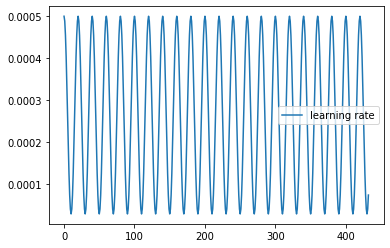


Epoch 00001: val_loss improved from inf to 0.73361, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00001: saving model to ../../../SpliceSite/snapshots/saved-model-01-0.73-fold_1.hdf5


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


_________________________________________ METRICS for epoch 0 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



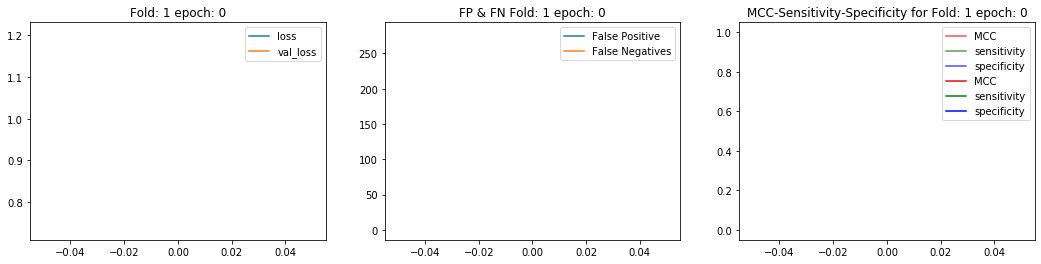

27680/27680 [==============================] - 27s 974us/sample - loss: 1.2074 - sensitivity: 0.3669 - specificity: 0.6720 - val_loss: 0.7336 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 2/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.7905 - sensitivity: 0.2094 - specificity: 0.8336

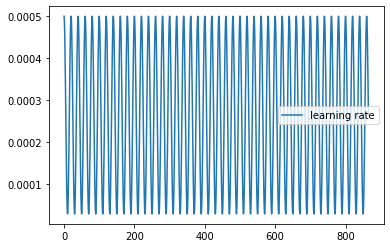


Epoch 00002: val_loss improved from 0.73361 to 0.60235, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00002: saving model to ../../../SpliceSite/snapshots/saved-model-02-0.60-fold_1.hdf5
_________________________________________ METRICS for epoch 1 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



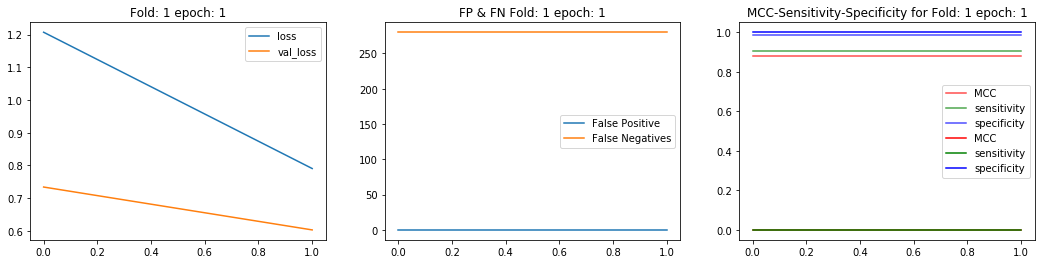

27680/27680 [==============================] - 24s 881us/sample - loss: 0.7903 - sensitivity: 0.2097 - specificity: 0.8337 - val_loss: 0.6024 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 3/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.5666 - sensitivity: 0.0236 - specificity: 0.9617- ETA: 6s - loss: 0.5899 - sensitivit - ETA: 3s - loss: 0.5792 -

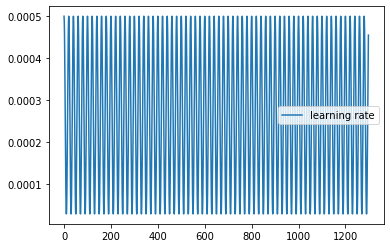


Epoch 00003: val_loss improved from 0.60235 to 0.44383, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00003: saving model to ../../../SpliceSite/snapshots/saved-model-03-0.44-fold_1.hdf5
_________________________________________ METRICS for epoch 2 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



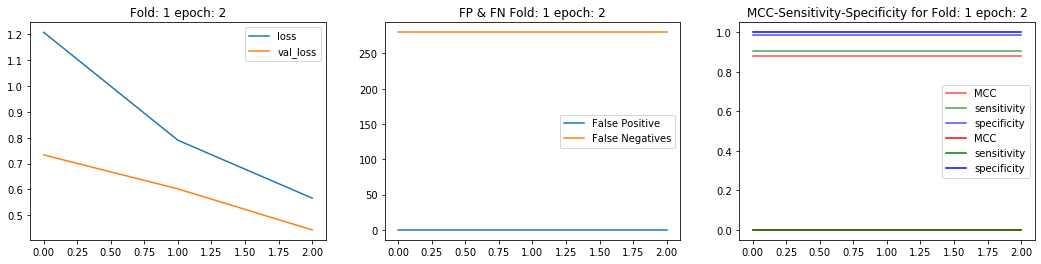

27680/27680 [==============================] - 24s 872us/sample - loss: 0.5666 - sensitivity: 0.0235 - specificity: 0.9617 - val_loss: 0.4438 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 4/200
27584/27680 [============================>.] - ETA: 0s - loss: 0.4547 - sensitivity: 0.0073 - specificity: 0.9887

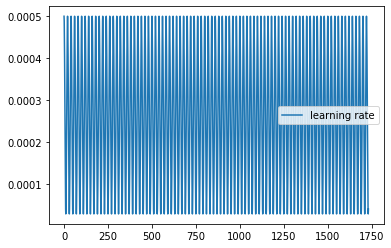


Epoch 00004: val_loss improved from 0.44383 to 0.37264, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00004: saving model to ../../../SpliceSite/snapshots/saved-model-04-0.37-fold_1.hdf5
_________________________________________ METRICS for epoch 3 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



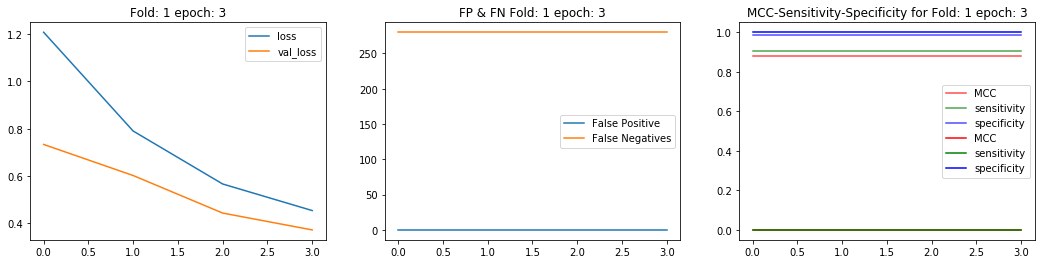

27680/27680 [==============================] - 24s 869us/sample - loss: 0.4544 - sensitivity: 0.0073 - specificity: 0.9887 - val_loss: 0.3726 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 5/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.3891 - sensitivity: 0.0020 - specificity: 0.9979

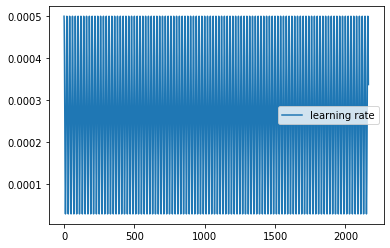


Epoch 00005: val_loss improved from 0.37264 to 0.31260, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00005: saving model to ../../../SpliceSite/snapshots/saved-model-05-0.31-fold_1.hdf5
_________________________________________ METRICS for epoch 4 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



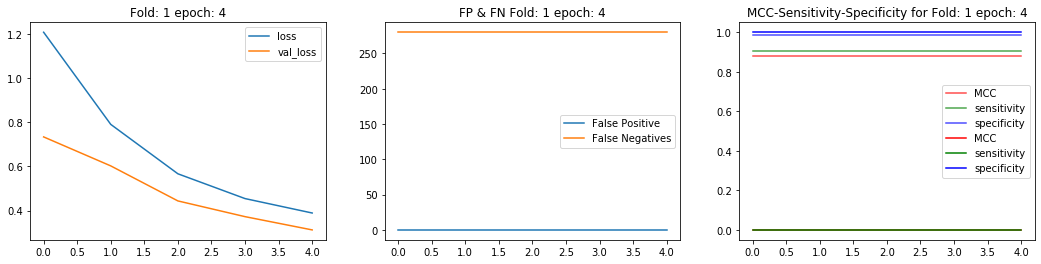

27680/27680 [==============================] - 24s 863us/sample - loss: 0.3891 - sensitivity: 0.0019 - specificity: 0.9979 - val_loss: 0.3126 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 6/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.3515 - sensitivity: 0.0056 - specificity: 0.9986

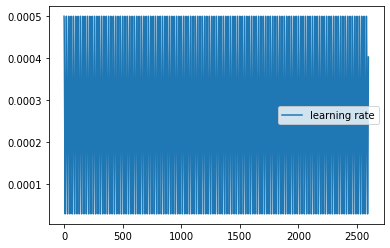


Epoch 00006: val_loss improved from 0.31260 to 0.28682, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00006: saving model to ../../../SpliceSite/snapshots/saved-model-06-0.29-fold_1.hdf5
_________________________________________ METRICS for epoch 5 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



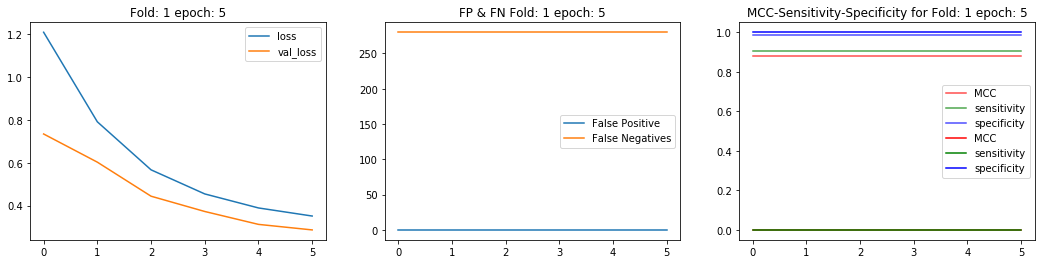

27680/27680 [==============================] - 24s 863us/sample - loss: 0.3515 - sensitivity: 0.0056 - specificity: 0.9986 - val_loss: 0.2868 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 7/200
27584/27680 [============================>.] - ETA: 0s - loss: 0.3227 - sensitivity: 0.0356 - specificity: 0.9962

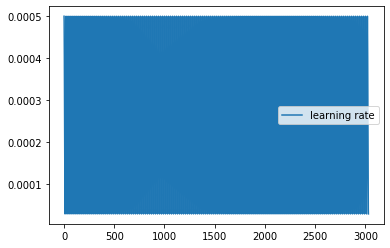


Epoch 00007: val_loss improved from 0.28682 to 0.26916, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00007: saving model to ../../../SpliceSite/snapshots/saved-model-07-0.27-fold_1.hdf5
_________________________________________ METRICS for epoch 6 _______________________________________________________
val_f1           :0.0  
val_precision    :0.0 
val_recall       :0.0
val_sensitivity  :0.00000   bmark:(0.9031)  sen.beaten:False
val_specificity  :1.00000   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.00000   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:0    | fp:0    |
| fn:280  | tn:2796 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



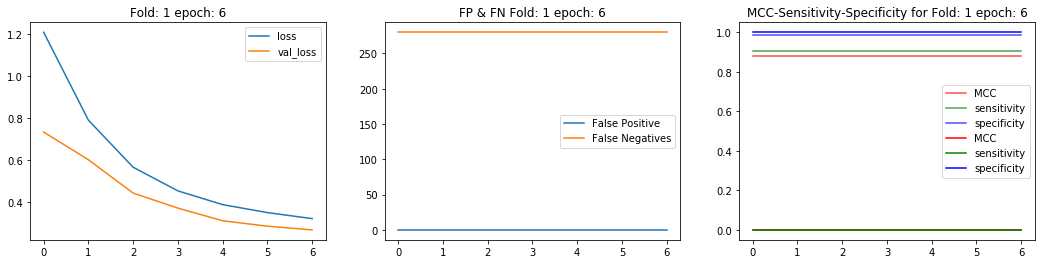

27680/27680 [==============================] - 24s 862us/sample - loss: 0.3227 - sensitivity: 0.0365 - specificity: 0.9962 - val_loss: 0.2692 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000
Epoch 8/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.2579 - sensitivity: 0.2464 - specificity: 0.9887

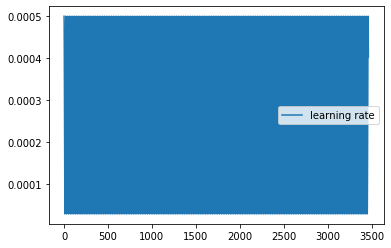


Epoch 00008: val_loss improved from 0.26916 to 0.22086, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00008: saving model to ../../../SpliceSite/snapshots/saved-model-08-0.22-fold_1.hdf5
_________________________________________ METRICS for epoch 7 _______________________________________________________
val_f1           :0.6747967479674797  
val_precision    :0.7830188679245284 
val_recall       :0.5928571428571429
val_sensitivity  :0.59286   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98355   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.65452   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:166  | fp:46   |
| fn:114  | tn:2750 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



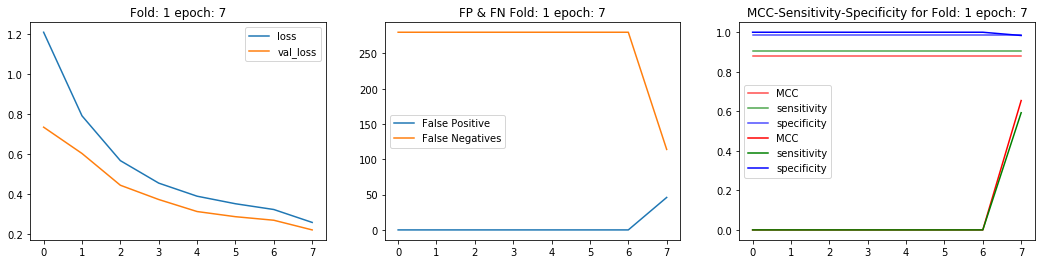

27680/27680 [==============================] - 24s 864us/sample - loss: 0.2582 - sensitivity: 0.2462 - specificity: 0.9887 - val_loss: 0.2209 - val_sensitivity: 0.5986 - val_specificity: 0.9840
Epoch 9/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.2166 - sensitivity: 0.4183 - specificity: 0.9847

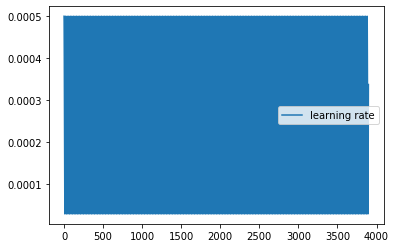


Epoch 00009: val_loss improved from 0.22086 to 0.14903, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00009: saving model to ../../../SpliceSite/snapshots/saved-model-09-0.15-fold_1.hdf5
_________________________________________ METRICS for epoch 8 _______________________________________________________
val_f1           :0.6377440347071582  
val_precision    :0.8121546961325967 
val_recall       :0.525
val_sensitivity  :0.52500   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98784   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.62685   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:147  | fp:34   |
| fn:133  | tn:2762 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



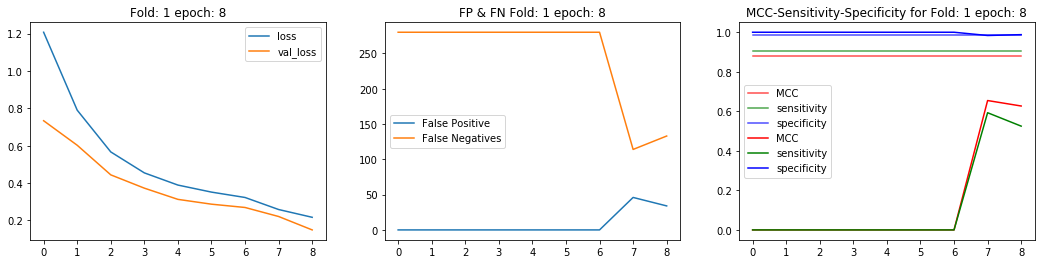

27680/27680 [==============================] - 24s 865us/sample - loss: 0.2165 - sensitivity: 0.4185 - specificity: 0.9846 - val_loss: 0.1490 - val_sensitivity: 0.5491 - val_specificity: 0.9880
Epoch 10/200
27584/27680 [============================>.] - ETA: 0s - loss: 0.1886 - sensitivity: 0.5320 - specificity: 0.9846

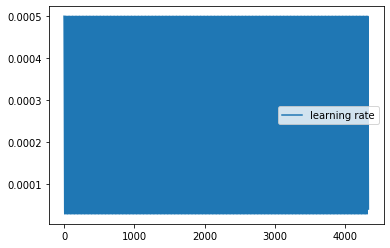


Epoch 00010: val_loss improved from 0.14903 to 0.12827, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00010: saving model to ../../../SpliceSite/snapshots/saved-model-10-0.13-fold_1.hdf5
_________________________________________ METRICS for epoch 9 _______________________________________________________
val_f1           :0.7206477732793523  
val_precision    :0.8317757009345794 
val_recall       :0.6357142857142857
val_sensitivity  :0.63571   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98712   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.70418   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:178  | fp:36   |
| fn:102  | tn:2760 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



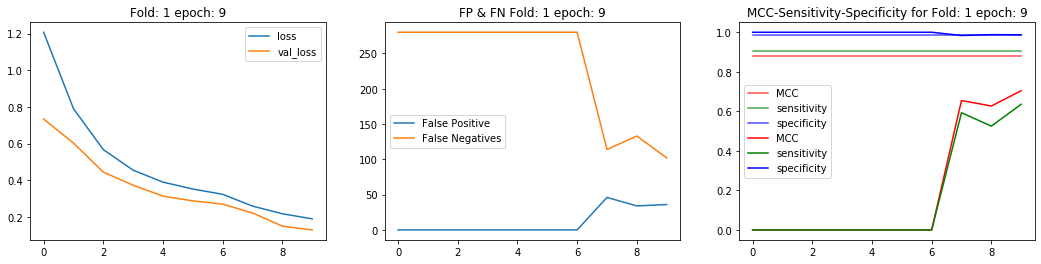

27680/27680 [==============================] - 24s 864us/sample - loss: 0.1887 - sensitivity: 0.5309 - specificity: 0.9847 - val_loss: 0.1283 - val_sensitivity: 0.6155 - val_specificity: 0.9874
Epoch 11/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1737 - sensitivity: 0.5380 - specificity: 0.9863

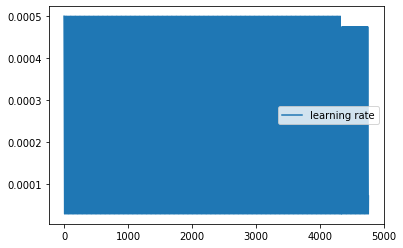


Epoch 00011: val_loss improved from 0.12827 to 0.11683, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00011: saving model to ../../../SpliceSite/snapshots/saved-model-11-0.12-fold_1.hdf5
_________________________________________ METRICS for epoch 10 _______________________________________________________
val_f1           :0.736  
val_precision    :0.8363636363636363 
val_recall       :0.6571428571428571
val_sensitivity  :0.65714   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98712   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.71916   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:184  | fp:36   |
| fn:96   | tn:2760 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



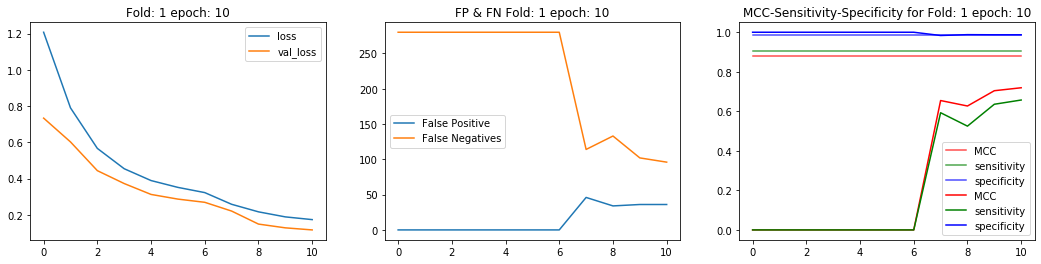

27680/27680 [==============================] - 24s 864us/sample - loss: 0.1737 - sensitivity: 0.5386 - specificity: 0.9864 - val_loss: 0.1168 - val_sensitivity: 0.6581 - val_specificity: 0.9872
Epoch 12/200
27584/27680 [============================>.] - ETA: 0s - loss: 0.1590 - sensitivity: 0.5834 - specificity: 0.9865

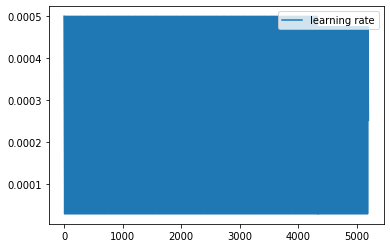


Epoch 00012: val_loss did not improve from 0.11683

Epoch 00012: saving model to ../../../SpliceSite/snapshots/saved-model-12-0.12-fold_1.hdf5
_________________________________________ METRICS for epoch 11 _______________________________________________________
val_f1           :0.8229342327150085  
val_precision    :0.7795527156549521 
val_recall       :0.8714285714285714
val_sensitivity  :0.87143   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.97532   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.80564   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:244  | fp:69   |
| fn:36   | tn:2727 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



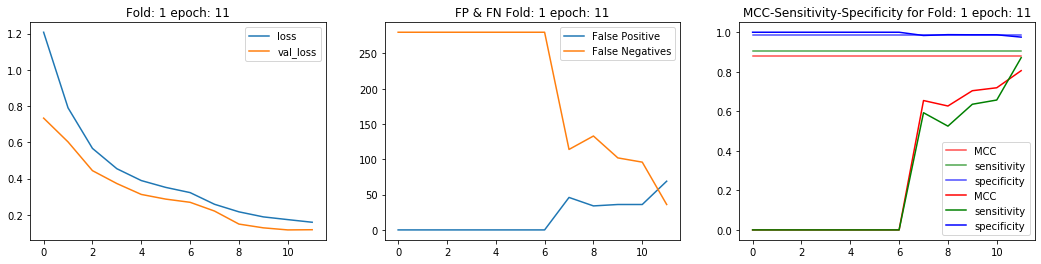

27680/27680 [==============================] - 24s 861us/sample - loss: 0.1591 - sensitivity: 0.5822 - specificity: 0.9865 - val_loss: 0.1179 - val_sensitivity: 0.8559 - val_specificity: 0.9758
Epoch 13/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1547 - sensitivity: 0.5853 - specificity: 0.9862

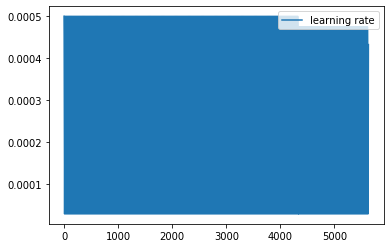


Epoch 00013: val_loss improved from 0.11683 to 0.10124, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00013: saving model to ../../../SpliceSite/snapshots/saved-model-13-0.10-fold_1.hdf5
_________________________________________ METRICS for epoch 12 _______________________________________________________
val_f1           :0.8133086876155269  
val_precision    :0.842911877394636 
val_recall       :0.7857142857142857
val_sensitivity  :0.78571   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98534   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.79592   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:220  | fp:41   |
| fn:60   | tn:2755 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



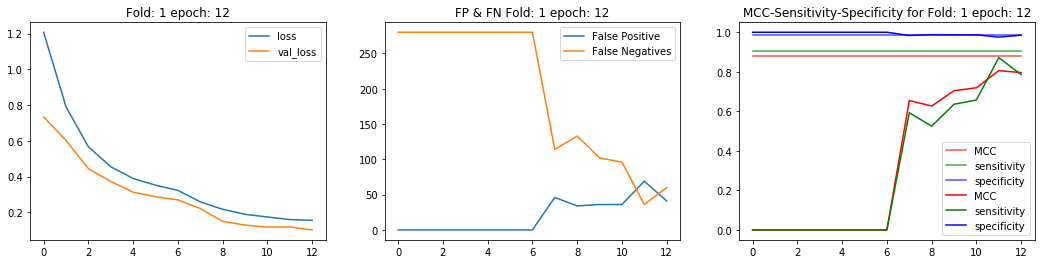

27680/27680 [==============================] - 24s 863us/sample - loss: 0.1547 - sensitivity: 0.5840 - specificity: 0.9863 - val_loss: 0.1012 - val_sensitivity: 0.7410 - val_specificity: 0.9857
Epoch 14/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1447 - sensitivity: 0.6184 - specificity: 0.9872

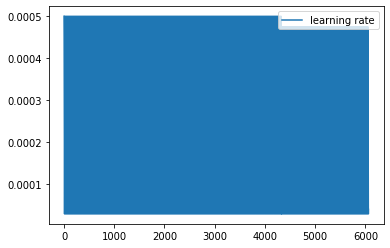


Epoch 00014: val_loss did not improve from 0.10124

Epoch 00014: saving model to ../../../SpliceSite/snapshots/saved-model-14-0.10-fold_1.hdf5
_________________________________________ METRICS for epoch 13 _______________________________________________________
val_f1           :0.8077669902912621  
val_precision    :0.8851063829787233 
val_recall       :0.7428571428571429
val_sensitivity  :0.74286   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.99034   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.79396   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:208  | fp:27   |
| fn:72   | tn:2769 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



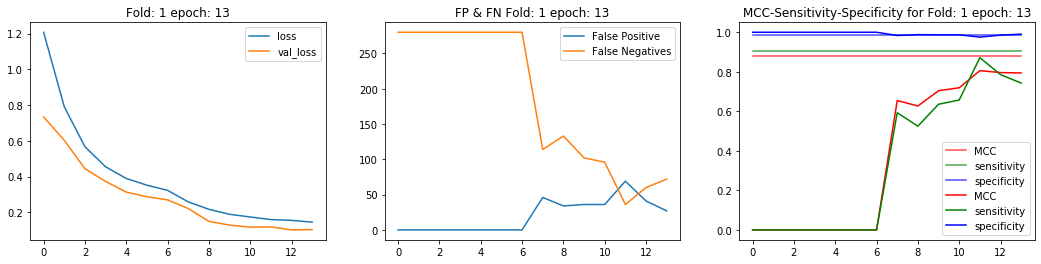

27680/27680 [==============================] - 24s 865us/sample - loss: 0.1446 - sensitivity: 0.6185 - specificity: 0.9872 - val_loss: 0.1030 - val_sensitivity: 0.7139 - val_specificity: 0.9906
Epoch 15/200
27584/27680 [============================>.] - ETA: 0s - loss: 0.1413 - sensitivity: 0.6080 - specificity: 0.9868

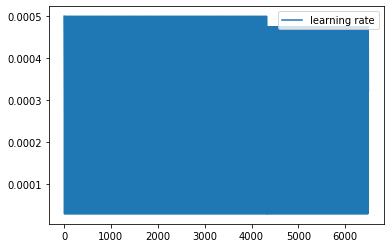


Epoch 00015: val_loss improved from 0.10124 to 0.09886, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00015: saving model to ../../../SpliceSite/snapshots/saved-model-15-0.10-fold_1.hdf5
_________________________________________ METRICS for epoch 14 _______________________________________________________
val_f1           :0.852233676975945  
val_precision    :0.8211920529801324 
val_recall       :0.8857142857142857
val_sensitivity  :0.88571   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98069   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.83755   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:248  | fp:54   |
| fn:32   | tn:2742 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



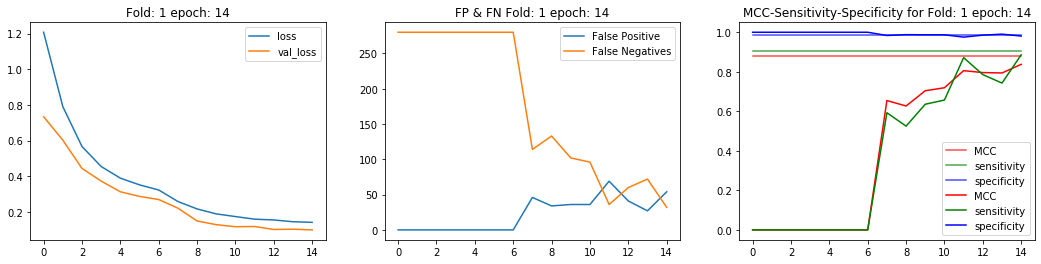

27680/27680 [==============================] - 24s 864us/sample - loss: 0.1414 - sensitivity: 0.6085 - specificity: 0.9867 - val_loss: 0.0989 - val_sensitivity: 0.8778 - val_specificity: 0.9810
Epoch 16/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1368 - sensitivity: 0.6169 - specificity: 0.9876

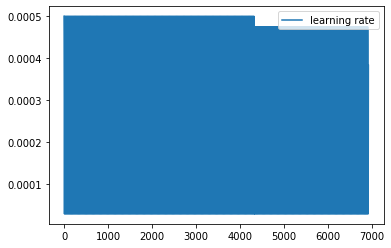


Epoch 00016: val_loss improved from 0.09886 to 0.08585, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00016: saving model to ../../../SpliceSite/snapshots/saved-model-16-0.09-fold_1.hdf5
_________________________________________ METRICS for epoch 15 _______________________________________________________
val_f1           :0.8470149253731344  
val_precision    :0.88671875 
val_recall       :0.8107142857142857
val_sensitivity  :0.81071   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98963   bmark:(0.9875)  spe.beaten:True
val_MCC          :0.83345   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:227  | fp:29   |
| fn:53   | tn:2767 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



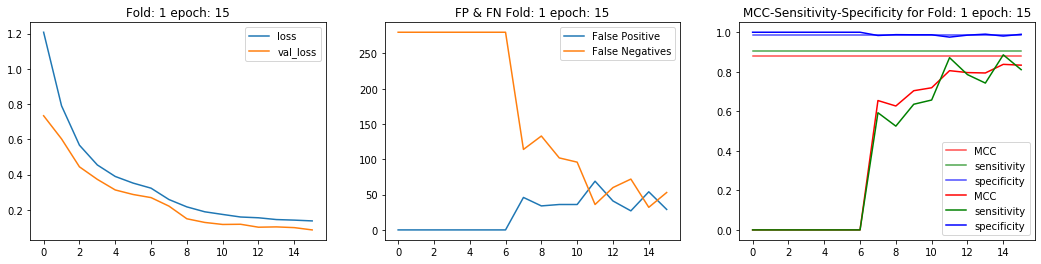

27680/27680 [==============================] - 24s 870us/sample - loss: 0.1369 - sensitivity: 0.6159 - specificity: 0.9875 - val_loss: 0.0859 - val_sensitivity: 0.7986 - val_specificity: 0.9898
Epoch 17/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1372 - sensitivity: 0.6172 - specificity: 0.9867

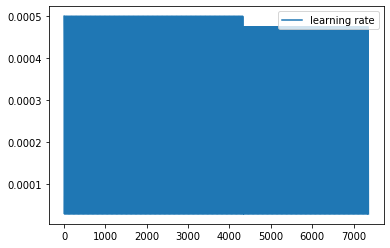


Epoch 00017: val_loss did not improve from 0.08585

Epoch 00017: saving model to ../../../SpliceSite/snapshots/saved-model-17-0.09-fold_1.hdf5
_________________________________________ METRICS for epoch 16 _______________________________________________________
val_f1           :0.8673469387755102  
val_precision    :0.827922077922078 
val_recall       :0.9107142857142857
val_sensitivity  :0.91071   bmark:(0.9031)  sen.beaten:True
val_specificity  :0.98104   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.85455   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:255  | fp:53   |
| fn:25   | tn:2743 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



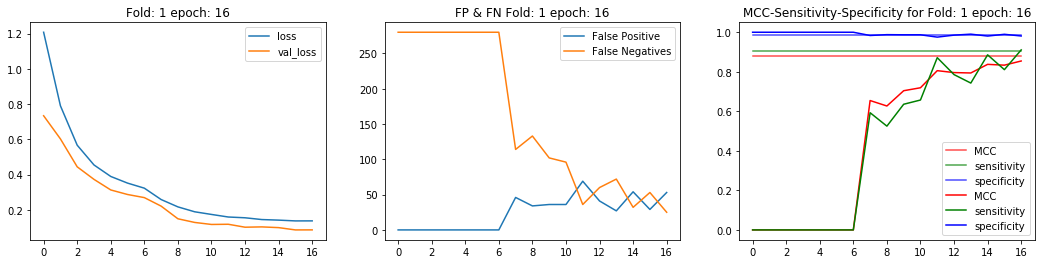

27680/27680 [==============================] - 24s 876us/sample - loss: 0.1371 - sensitivity: 0.6181 - specificity: 0.9867 - val_loss: 0.0860 - val_sensitivity: 0.9228 - val_specificity: 0.9814
Epoch 18/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1325 - sensitivity: 0.6481 - specificity: 0.9884

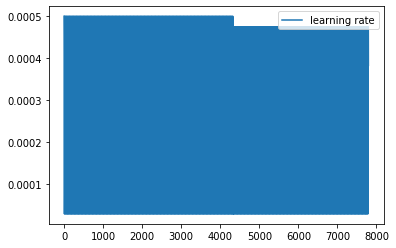


Epoch 00018: val_loss did not improve from 0.08585

Epoch 00018: saving model to ../../../SpliceSite/snapshots/saved-model-18-0.09-fold_1.hdf5
_________________________________________ METRICS for epoch 17 _______________________________________________________
val_f1           :0.8396396396396397  
val_precision    :0.8472727272727273 
val_recall       :0.8321428571428572
val_sensitivity  :0.83214   bmark:(0.9031)  sen.beaten:False
val_specificity  :0.98498   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.82378   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:233  | fp:42   |
| fn:47   | tn:2754 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



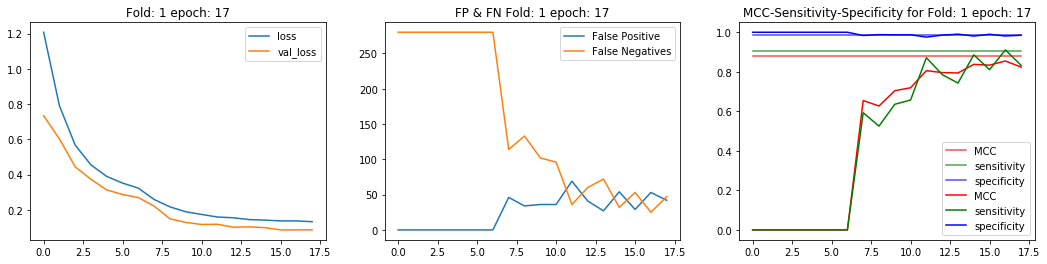

27680/27680 [==============================] - 24s 874us/sample - loss: 0.1324 - sensitivity: 0.6489 - specificity: 0.9883 - val_loss: 0.0865 - val_sensitivity: 0.8137 - val_specificity: 0.9854
Epoch 19/200
27648/27680 [============================>.] - ETA: 0s - loss: 0.1286 - sensitivity: 0.6535 - specificity: 0.9874

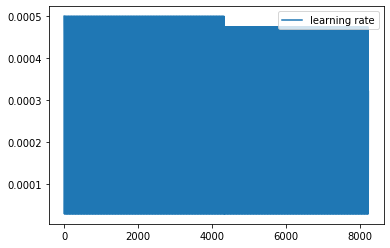


Epoch 00019: val_loss improved from 0.08585 to 0.08571, saving model to ../../../SpliceSite/snapshots/1_Weights_bestModel.h5

Epoch 00019: saving model to ../../../SpliceSite/snapshots/saved-model-19-0.09-fold_1.hdf5
_________________________________________ METRICS for epoch 18 _______________________________________________________
val_f1           :0.8656716417910447  
val_precision    :0.8080495356037152 
val_recall       :0.9321428571428572
val_sensitivity  :0.93214   bmark:(0.9031)  sen.beaten:True
val_specificity  :0.97783   bmark:(0.9875)  spe.beaten:False
val_MCC          :0.85383   bmark:(0.8799)  mcc.beaten:False
---------------------
| tp:261  | fp:62   |
| fn:19   | tn:2734 |
---------------------

_________________________________________ EPOCH END _______________________________________________________________________



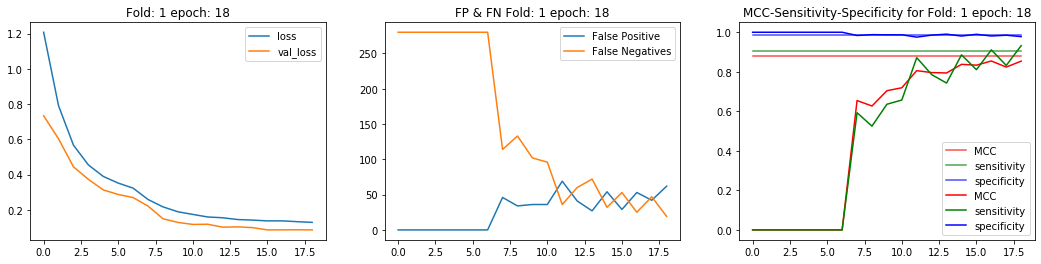

27680/27680 [==============================] - 24s 880us/sample - loss: 0.1285 - sensitivity: 0.6543 - specificity: 0.9873 - val_loss: 0.0857 - val_sensitivity: 0.9289 - val_specificity: 0.9782
Epoch 20/200
 4672/27680 [====>.........................] - ETA: 17s - loss: 0.1238 - sensitivity: 0.6432 - specificity: 0.9893

KeyboardInterrupt: 

In [48]:
########################### Stratified k-fold Cross validation ###############

# train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels,
#                                                                                 test_size=hyper_test_split,
#                                                                                 stratify=input_labels,
#                                                                                 random_state=42)



dfROC =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
dfROC_best =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
dfROC_train =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   
dfROC_best_train =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   

dfPR  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
dfPR_best  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
dfPR_train  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )
dfPR_best_train  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )


dfCM      = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
dfCM_best = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
dfCM_train      = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])
dfCM_best_train = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])    

training_histories = []
last_model_performance_histories = []
best_model_performance_histories = []

last_model_performance_histories_trainset = []
best_model_performance_histories_trainset = []


skf = StratifiedKFold( n_splits= k_folds , random_state = 23, shuffle=True)
print(skf)  
k=0


for train_index, test_index in skf.split(sequences, labels):
    
    # fold K
    k=k+1;
    
    print()    
    print()    
    print(" --------------- Fold:", k, " ---------------")
    print("train fold size:", len(train_index ), "\nValidation fold size:", len(test_index) )

    # get the features and labels for the train set
    train_features = input_features[train_index]
    train_labels   = labels[train_index]#input_labels[train_index]
    
    # get the features and labels for the validation set
    test_features = input_features[test_index]
    test_labels   = labels[test_index]#input_labels[test_index] 

    # feature dimension
    inputSeqLength = len(train_features[0]);
    inputSeqLength = np.array(train_features).shape[1];
    
    size0 = np.array(train_features).shape[0];
    size1 = np.array(train_features).shape[1];
    print("number of samples in Training: " + str(size0) + "  seq length: " + str(size1))

    size0 = np.array(test_features).shape[0];
    size1 = np.array(test_features).shape[1];
    print("number of samples in Testing : " + str(size0) + "  seq length: " + str(size1))

    size0 = np.array(input_features).shape[0];
    size1 = np.array(input_features).shape[1];
    print("number of samples in used dataset: " + str(size0) + "  seq length: " + str(size1))
        
    print('Building model')

    model, config = make_model()

    learning_rate = config['learning_rate']

#     decay_rate = learning_rate / hyper_epoch

    adamOpt = Adam(lr = 0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad = False)
    #model.compile(loss='binary_crossentropy', optimizer=adamOpt, metrics=[sensitivity, specificity]) # 'adam' , metrics=['binary_accuracy', my_pred]
    model.compile(loss='binary_crossentropy', optimizer=adamOpt, metrics=[sensitivity, specificity]) # 'adam' , metrics=['binary_accuracy', my_pred]
    
    #model.compile(loss='binary_crossentropy', optimizer=adamOpt, metrics=[sensitivity, specificity,'binary_accuracy']) # 'adam' , metrics=['binary_accuracy', my_pred]
    
    # Adadelta didn't give us good result. we omitted it.
    #model.compile(loss='binary_crossentropy', optimizer='Adadelta', metrics=['binary_accuracy']) # 'adam' , metrics=['binary_accuracy', my_pred]
    
    print ( model.summary() )
    
    
    print('Running at most', hyper_epoch, 'epochs')

    print()
    print("************************************************************ ")        
    print("************** TRAINING START (fold", k, ") **************** ")
    # https://machinelearningmastery.com/check-point-deep-learning-models-keras/
    
    fileWeight_BestModel = f"{snapshot_dir}{k}_Weights_bestModel.h5"
    every_epoch_checkpoint_fname = snapshot_dir+"saved-model-{epoch:02d}-{val_loss:.2f}-fold_"+str(k)+".hdf5"
    
    #     monitor='val_loss', mode='min'
    #     monitor='val_acc', mode='max'
    #     monitor='val_fmeasure', mode='max'
    
    
    best_checkpoint = ModelCheckpoint(fileWeight_BestModel, monitor='val_loss',mode='auto', save_best_only=True, verbose=1, save_weights_only=True )
    every_epoch_checkpoint = ModelCheckpoint(filepath = every_epoch_checkpoint_fname, monitor='val_loss', verbose=1, save_best_only=False, 
                                             save_weights_only=False, mode='auto', period=1)
    #     val_loss,val_binary_accuracy,loss,binary_accuracy
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')

    schedule = SGDRScheduler(min_lr = config['SGDRScheduler_config']['min_lr'],
                             max_lr = config['SGDRScheduler_config']['max_lr'],
                             steps_per_epoch = config['SGDRScheduler_config']['steps_per_epoch'],
                             lr_decay = config['SGDRScheduler_config']['lr_decay'],
                             cycle_length = config['SGDRScheduler_config']['cycle_length'],
                             mult_factor = config['SGDRScheduler_config']['mult_factor'])
    


    metrics = Metrics(val_data  = (test_features, test_labels))
    metrics.set_benchmark(b_sensitivity = 0.9031, b_specificity = 0.9875, b_mcc = 0.8799)   # for 1:10
    metrics.set_fold(k)
 
    # for plotting losses        
    loss_plotter = Plotter()
    loss_plotter.set_plot_color(k-1)
    loss_plotter.setMetrics(metrics)
    
    history = model.fit(train_features, train_labels, epochs= hyper_epoch, batch_size=hyper_batch_size, shuffle=True, verbose=1, 
                        validation_data = (test_features, test_labels), callbacks=[schedule, best_checkpoint, every_epoch_checkpoint, metrics, loss_plotter] )    
    #class_weight=class_weight , 
    
    training_histories.append(history)

    # using validation set fold for validation
    #history = model.fit(train_features, train_labels, epochs= hyper_epoch, batch_size=hyper_batch_size, shuffle=True, verbose=1, 
    #                    validation_data = (test_features, test_labels), class_weight=class_weight , callbacks=[early_stopping, checkpoint] )  
    
    
    # save the last iteration's model and weights
    fileModel = f'{snapshot_dir}{k}_Model.h5'
    model.save(fileModel)
    fileWeight = f'{snapshot_dir}{k}_Weights.h5'
    model.save_weights(fileWeight)

    print("************** TRAINING END (fold", k, ") **************** ")
    print("********************************************************** ")        

    
    print("************************************************************************ ")            
    print("************** TESTING START (LAST MODEL) (fold", k, ") **************** ")
    
    last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
    print(last_model_weight_file)
    model.load_weights(last_model_weight_file, by_name=False)

    test_summary = perform_test(model, test_features, test_labels, dfCM, dfROC, dfPR )
    last_model_performance_histories.append(test_summary)    
        
    print("************** TESTING END (LAST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")            
    
    
    print("************************************************************************ ")            
    print("************** TESTING START (BEST MODEL) (fold", k, ") **************** ")
    best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
    print(fileWeight_BestModel)
    model.load_weights(best_model_weight_file, by_name=False)

    test_summary = perform_test(model, test_features, test_labels, dfCM_best, dfROC_best, dfPR_best )
    best_model_performance_histories.append(test_summary)    
    
    print("************** TESTING END  (BEST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")   

    
    print("************************************************************************ ")            
    print("************** TESTING START ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
    last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
    print(last_model_weight_file)
    model.load_weights(last_model_weight_file, by_name=False)

    test_summary = perform_test(model, train_features, train_labels, dfCM_train, dfROC_train, dfPR_train )
    last_model_performance_histories_trainset.append(test_summary) 
    
    print("************** TESTING END ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")
    
    print("************************************************************************ ")            
    print("************** TESTING START ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
    best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
    print(fileWeight_BestModel)
    model.load_weights(best_model_weight_file, by_name=False)

    test_summary = perform_test(model, train_features, train_labels, dfCM_best_train, dfROC_best_train, dfPR_best_train )
    best_model_performance_histories_trainset.append(test_summary)
    
    print("************** TESTING END ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")    
    
##########################  Split End ###############################

In [ ]:
def test_metrics():
    k = 1
    print("************************************************************************ ")            
    print("************** TESTING START (LAST MODEL) (fold", k, ") **************** ")
    
    last_model_weight_file = f'{snapshot_dir}saved-model-114-0.40-fold_{k}.hdf5'
    print(last_model_weight_file)
    model.load_weights(last_model_weight_file, by_name=False)

    test_summary = perform_test(model, test_features, test_labels, dfCM, dfROC, dfPR )
    last_model_performance_histories.append(test_summary)    
        
    print("************** TESTING END (LAST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")            
   
    
    print("************************************************************************ ")            
    print("************** TESTING START (BEST MODEL) (fold", k, ") **************** ")
    best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
    print(fileWeight_BestModel)
    model.load_weights(best_model_weight_file, by_name=False)

    test_summary = perform_test(model, test_features, test_labels, dfCM_best, dfROC_best, dfPR_best )
    best_model_performance_histories.append(test_summary)    
    
    print("************** TESTING END  (BEST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ")   

    
#     print("************************************************************************ ")            
#     print("************** TESTING START ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
#     last_model_weight_file = f'{snapshot_dir}{k}_Weights.h5'
#     print(last_model_weight_file)
#     model.load_weights(last_model_weight_file, by_name=False)

#     test_summary = perform_test(model, train_features, train_labels, dfCM_train, dfROC_train, dfPR_train )
#     last_model_performance_histories_trainset.append(test_summary) 
    
#     print("************** TESTING END ON TRAINING SET (LAST MODEL) (fold", k, ") **************** ")
#     print("************************************************************************ ")
    
    print("************************************************************************ ")            
    print("************** TESTING START ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
    best_model_weight_file = f"{snapshot_dir}{k}_Weights_bestModel.h5"
    print(fileWeight_BestModel)
    model.load_weights(best_model_weight_file, by_name=False)

    test_summary = perform_test(model, train_features, train_labels, dfCM_best_train, dfROC_best_train, dfPR_best_train )
    best_model_performance_histories_trainset.append(test_summary)
    
    print("************** TESTING END ON TRAINING SET (BEST MODEL) (fold", k, ") **************** ")
    print("************************************************************************ ") 

In [ ]:
test_metrics()

In [ ]:
def plot_training_histories():
    
    for history in training_histories:
        # Plot training & validation accuracy values
#         plt.plot(history.history['binary_accuracy'])
#         plt.plot(history.history['val_binary_accuracy'])
#         plt.title('Model accuracy')
#         plt.ylabel('Accuracy')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Test'], loc='upper left')
#         plt.show()

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()    
        
#plot_training_histories()       

In [ ]:
#
# load a model from file and evaluate its performance
#
#

# dfROC_best_val =  pd.DataFrame(data=None, columns=['AREA_ROC'] )   

# dfPR_best_val  =  pd.DataFrame(data=None, columns=['AREA_PR' ] )

# dfCM_best_val = pd.DataFrame(data=None, columns=['tp', 'fn' , 'fp' , 'tn'])    

# for k in range(1,11):
#     best_model_weight_file = f"{ds_dir}{k}_Weights_bestModel.h5"
#     print("************************* ",k, " **************************")
#     print(fileWeight_BestModel)
#     model.load_weights(best_model_weight_file, by_name=False)

#     perform_test(model, test_features, test_labels, dfCM_best_val, dfROC_best_val, dfPR_best_val )
#     print()
#     print()
    

In [ ]:
# generate loss plots for all the folds along with the corresponding performance metrics
# and write the result to a PDF file

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

with PdfPages('test.pdf') as pdf:
    t = np.arange(0.0, 2.0, 0.01)
    s = 1 + np.sin(2*np.pi*t)
    s = s * 50

    fig = plt.figure(figsize=(12,12))
    n=0
    
    for history in training_histories:
        n += 1
        ax = fig.add_subplot(4,3,n)

        # Plot training & validation loss values
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.yaxis.set_label_text('Loss')
        ax.xaxis.set_label_text('Epoch')
        ax.legend(['Train', 'Test'], loc='upper right')            

    pdf.savefig(fig)

In [ ]:
print('*********** AREA ROC for BEST model *************')

for index, row in dfROC_best.iterrows():
        print(  row['AREA_ROC']  )
        
print( dfROC_best.mean(axis = 0, skipna = True)  )

print('*********** AREA ROC for BEST model END *************')


print('*********** AREA PR for BEST model *************')

for index, row in dfPR_best.iterrows():
        print(  row['AREA_PR']  )
        
print( dfPR_best.mean(axis = 0, skipna = True)  )

print('*********** AREA PR for BEST model END *************')

In [ ]:
print('*********** CV  for last iteration model *************')

for index, row in dfCM.iterrows():
        print(  row['tp'], row['fn'] ,  row['fp'], row['tn']  )

print( dfCM.sum(axis = 0, skipna = True)  )

dfTotal=dfCM.sum(axis = 0, skipna = True) 
total_tp = dfTotal['tp'];
total_fn = dfTotal['fn'];
total_fp = dfTotal['fp'];
total_tn = dfTotal['tn'];
total_all = total_tp + total_fn + total_fp + total_tn;
accuracy1=(total_tp+total_tn)/total_all
sensitivity1 = total_tp/(total_tp+total_fn)
specificity1 = total_tn/(total_fp+total_tn)
if (total_tp)==0:
    precision1 = 0
else:
    precision1 = total_tp / (total_tp + total_fp)

MCC = (total_tp*total_tn - total_fp*total_fn) / np.sqrt(  (total_tp+total_fp)*(total_tp+total_fn)*(total_tn+total_fp)*(total_tn+total_fn)  ) 

print("TOTAL RECORDS IN ALL FOLD OF CV " , total_all)
print(  "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC ))



print('*********** CV  for best model *************')
for index, row in dfCM_best.iterrows():
        print(  row['tp'], row['fn'] ,  row['fp'], row['tn']  )
        
        
print( dfCM_best.sum(axis = 0, skipna = True)  )

dfTotal=dfCM_best.sum(axis = 0, skipna = True) 
total_tp = dfTotal['tp'];
total_fn = dfTotal['fn'];
total_fp = dfTotal['fp'];
total_tn = dfTotal['tn'];
total_all = total_tp + total_fn + total_fp + total_tn;
accuracy1=(total_tp+total_tn)/total_all
sensitivity1 = total_tp/(total_tp+total_fn)
specificity1 = total_tn/(total_fp+total_tn)
if (total_tp)==0:
    precision1 = 0
else:
    precision1 = total_tp / (total_tp + total_fp)

MCC = (total_tp*total_tn - total_fp*total_fn) / np.sqrt(  (total_tp+total_fp)*(total_tp+total_fn)*(total_tn+total_fp)*(total_tn+total_fn)  ) 

print("TOTAL RECORDS IN ALL FOLD OF CV " , total_all)
print(  "Precision : " + str(precision1) + " Sensitivity/Recall: " + str (sensitivity1) + " Specificity: " + str(specificity1 )  + " Accuracy: " + str(accuracy1 ) + " MCC: " + str(MCC ))


In [ ]:
##########################  PR curve Drawing ###############################

test_label_rep = test_labels
pred_data = predicted_labels
cm1 = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))


print("********* Precision-Recall Curve *********")

average_precision = average_precision_score(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))
print('Average Precision (AUPR)' , average_precision)
precision, recall, _ = precision_recall_curve(np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1))


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

##########################  PR curve Drawing END ###############################

In [ ]:

##########################  ROC curve Drawing START ###############################
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html



print("********* Receiver Operating Curve *********")
print ('AUC: '+str(roc_auc_score( np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1) ) ) )

fpr, tpr, thresholds = roc_curve(  np.argmax(test_labels, axis=1), np.argmax(predicted_labels, axis=1)  )
roc_auc = auc(fpr, tpr)

lw=2;
plt.plot(fpr, tpr, lw=lw, alpha=0.3, label='ROC'  )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


##########################  ROCcurve Drawing END ###############################

In [ ]:
########################## Cross-validated ROC curve Drawing START ###############################
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py


print(cm)
print(history)

import json
# Get the dictionary containing each metric and the loss for each epoch
#history_dict = history
#print(history_dict['loss'][49])

########################## Cross-validated ROC curve Drawing END ###############################